In [1]:
import sys

# Specify the directory you want to add
custom_path = './..'

# Add the directory to sys.path
if custom_path not in sys.path:
    sys.path.append(custom_path)

In [2]:
from __future__ import absolute_import
import importlib


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from models import MLP, OneOverSqr
from runners import wrap_runner_for_optimization
from fitting_utils import create_fitting_loss
from dsp_utils import smooth_signal

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
!ls

DELETE_THIS_empty.ipynb				 sweek_k1k3_try2_14.log
ZZZZ_nl_experiments_tanh.ipynb			 sweek_k1k3_try2_15.log
ZZZ_bkp_oldReLU.ipynb				 sweek_k1k3_try2_16.log
ZZZ_delete_nl_experiments-Copy4.ipynb		 sweek_k1k3_try2_17.log
__init__.py					 sweek_k1k3_try2_18.log
antifrog_demo.ipynb				 sweek_k1k3_try2_19.log
avraham_data_bringup.ipynb			 sweek_k1k3_try2_2.log
basline_example_forDK.ipynb			 sweek_k1k3_try2_20.log
collect_fitting_info101-3a-BUGBUG.ipynb		 sweek_k1k3_try2_21.log
collect_fitting_info101-3a-val.ipynb		 sweek_k1k3_try2_22.log
collect_fitting_info101-3a.ipynb		 sweek_k1k3_try2_23.log
collect_fitting_info101.ipynb			 sweek_k1k3_try2_3.log
debug_full_repertoire.ipynb			 sweek_k1k3_try2_4.log
fit_single_v1.py				 sweek_k1k3_try2_5.log
focus_on_comboNerr_sweeps.ipynb			 sweek_k1k3_try2_6.log
focus_on_combo_sweeps.ipynb			 sweek_k1k3_try2_7.log
focus_on_error_learning.ipynb			 sweek_k1k3_try2_8.log
focus_on_error_learning_gauss.ipynb		 sweek_k1k3_try2_9.log
focus_on_error_learning_sw

In [4]:
opt_data = {}
for i in range(24):
    with open(f'../results/sweep_3a_subj_{i}.pkl','rb') as f:
        opt_data[i] = pickle.load(f)

In [5]:
opt_data

{0: {'MSE':                         fun: 146.61059474582464
   lowest_optimization_result:       fun: 146.61059474582464
   hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
        jac: array([   0.        , 1265.68367089,    0.        ,   -1.51440803])
    message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
       nfev: 95
        nit: 3
       njev: 19
     status: 0
    success: True
          x: array([-4.05139016, -0.32153751,  0.20677529, 41.17324129])
                      message: ['requested number of basinhopping iterations completed successfully']
        minimization_failures: 8
                         nfev: 6025
                          nit: 50
                         njev: 1205
                            x: array([-4.05139016, -0.32153751,  0.20677529, 41.17324129])},
 1: {'MSE':                         fun: 121.35853828906174
   lowest_optimization_result:       fun: 121.35853828906174
   hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
        jac

In [6]:


fixed_params = {}


fixed_params['model'] =  dict(n_inputs = 3,
                  n_hidden = 5*4*512,
                  n_outs = 1,
                  en_bias = False,
                 b_high=3, first_layer_init='ones',
                first_layer_weights_trainable = True,
                out_layer_init='zeros')         
#todo - tie "kernel width" to learning rate 
fixed_params['runner'] = {'criterion':'MSE', 'k':[0,1,0], 'sigma_noi':0.0, 'tau_u':1,
                          'save_model_at_init':False, 'ic_param_file':None}

def scale_and_bias(x,bias=0,scale=45.0):
    x = np.array(x)
    return x*scale + bias
#to sweep

# nl = lambda : OneOverSqr(w=w), 
# skip_gain= skip
# , 'learning_rate':1e-5

optim_param_mapping= [('runner','learning_rate',lambda x: 10.**x), 
                      ('model','skip_gain'), 
                      ('model','nl',
                       lambda w: (lambda : OneOverSqr(w=w))),
                     ('postprocessing','scale')]

wrapped_runner = wrap_runner_for_optimization(model_class=MLP, 
                                             fixed_params=fixed_params,
                                             optim_params_mapping=optim_param_mapping,
                                             postprocessing_fun=scale_and_bias)


In [7]:
df = pd.read_csv('../../../frogs_project/data/avraham__ivry_fig1_rotFig1_v2.csv',header=None)
df = df.T
data = df.to_numpy()

In [8]:
stimulus = [(1,40),(0,40)]
pooling_fun = 'MSE'

In [9]:
errors = [opt_data[k][pooling_fun]['fun'] for k in opt_data]


In [10]:
np.mean(errors)

81.11437928355052

In [16]:
outs  = {k: wrapped_runner([(1,40),(0,40),(1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data}

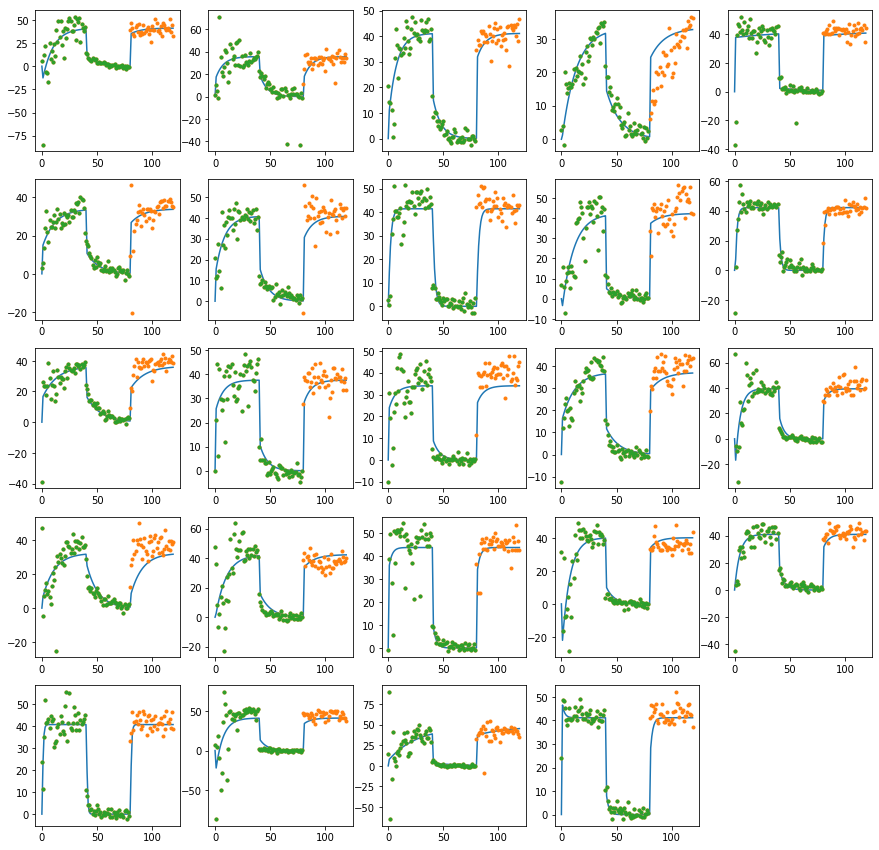

In [52]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k])
    plt.plot(data[:,k],'.')
    plt.plot(data[:80,k],'.')

# plt.plot(data[:80,0],'.')
# plt.plot(smooth_signal(data[:,0],3))


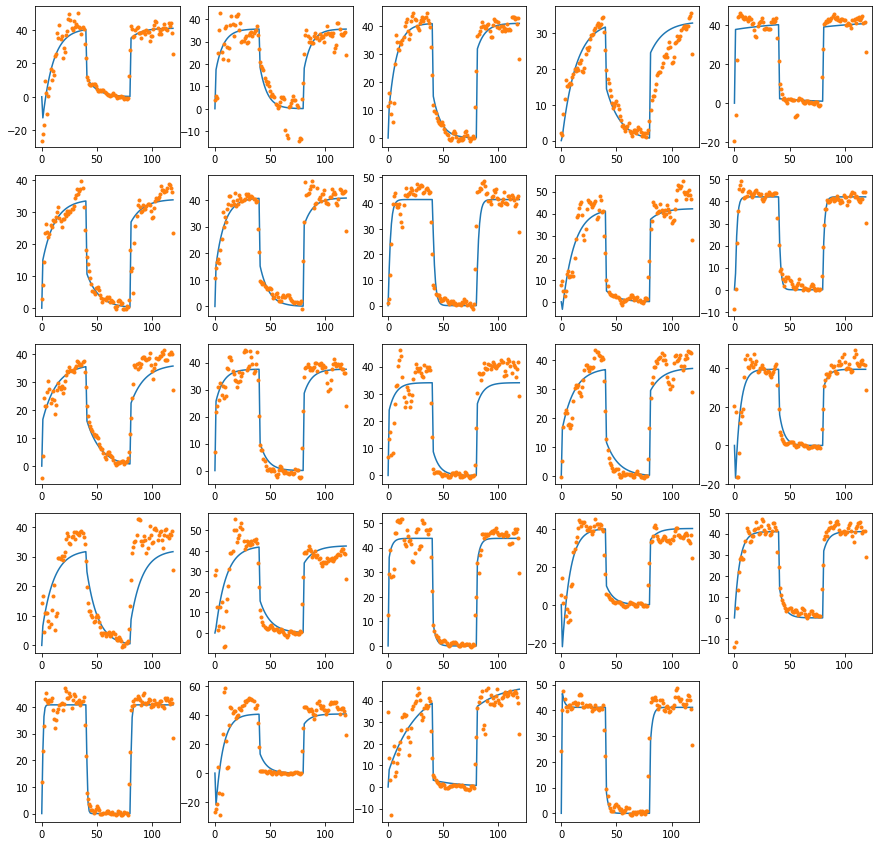

In [18]:
plt.figure(figsize=(15,15))
for k in opt_data:
    plt.subplot(5,5,k+1)
    plt.plot(outs[k])
    plt.plot(smooth_signal(data[:,k],3),'.')

In [37]:
outs_ = [o for _,o in outs.items()]
outs_ = np.array(outs_)

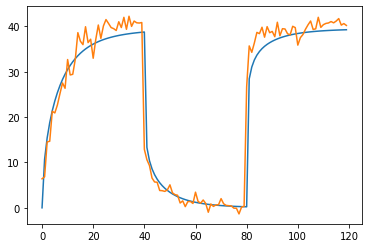

In [23]:
plt.plot(np.mean(outs_,axis=0))
plt.plot(np.mean(data,axis=1))

In [38]:
diffs = outs_.T-data
np.mean(diffs[:80,:]**2),np.mean(diffs[80:,:]**2)

In [49]:
data_varia = data-np.mean(data,axis=1,keepdims=True)

In [42]:
np.mean(data_varia[]**2)

array([[ -5.77      ,  -1.65      , -20.55      , ...,  -6.95      ,
        -14.45      , -24.14      ],
       [ 71.9727736 ,   6.88473073,  -3.05210582, ...,  64.8416584 ,
        -82.20155403,  -2.15124646],
       [-19.5681657 ,  14.46909027,   1.03505256, ..., -17.92561317,
         74.52757353,  -3.63597942],
       ...,
       [  4.12138354,   5.04453349,  -3.88567403, ...,  -0.28204004,
          2.17542678,  -1.3828667 ],
       [ -3.76464763,  -1.97149627,   3.08310971, ...,  -0.12785956,
          6.19290467,  -1.1028667 ],
       [  8.44794199,   1.3706195 ,  -5.51921584, ...,   3.13573975,
          9.99669987,   4.1371333 ]])

In [56]:
np.mean(diffs[:80,:]**2),np.mean(diffs[80:,:]**2),np.mean(diffs[81:,:]**2)

(81.11438157674134, 67.12514513840335, 45.84445015854198)

In [55]:
np.mean(data_varia[:80,:]**2),np.mean(data_varia[80:,:]**2),np.mean(data_varia[81:,:]**2)

(99.77897536675346, 50.27909636284723, 46.55323259882478)

[]

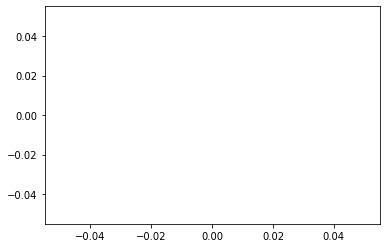

In [46]:
plt.plot(diffs[:,80:])

In [26]:
A_times = [0,5,10,20] 
antero   = {aa: [ wrapped_runner([(1,A_time),(-1,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,A_time in enumerate(A_times)}

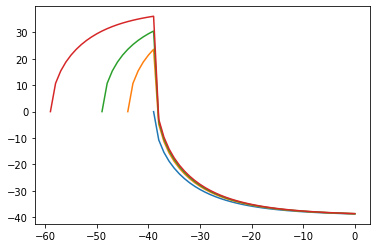

In [29]:
for aa,A_time in enumerate(A_times):
    y = np.mean(antero[aa],axis=0)
    x = np.arange(len(y))
    x = x - x[-1]
    plt.plot(x,y)
    

In [33]:
frog_ens = [True,False]
Tfrog = 120
frogs   = {aa: [ wrapped_runner([(1 if not frog_en else np.linspace(0,1,Tfrog),Tfrog),(0,40)],opt_data[k][pooling_fun]['x']) for k in opt_data] for aa,frog_en in enumerate(frog_ens)}

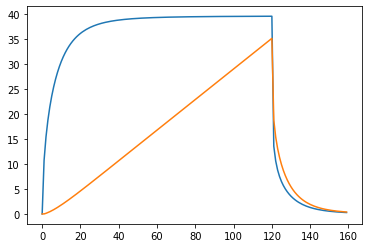

In [34]:
for frog_en in frog_ens:
    plt.plot(np.mean(frogs[frog_en],axis=0))

In [15]:
for setting in pooling_funs +[appendix]:
    plt.plot(outs[setting])
plt.plot(data[:,0],'x')
plt.plot(data[:80,0],'x')

plt.xlim([39,120])
plt.ylim([-5,60])


NameError: name 'pooling_funs' is not defined

In [ ]:
mae = lambda x: np.mean(np.abs(x))
mse = lambda x: np.mean(np.square(x))


In [ ]:
for setting in pooling_funs +[appendix]:
    fit_err = outs[setting][:80] - data[:80,0]
    val_err = outs[setting][80:] - data[80:,0]
    print(f'fit objective: {setting}')
    print(f' fitting MAE: {mae(fit_err)}; MSE: {mse(fit_err)}')
    print(f' validation MAE: {mae(val_err)}; MSE: {mse(val_err)}')

In [ ]:
import scipy
scipy.__version__

In [ ]:
# !pip3 install --upgrade pip

In [ ]:
# pip install --upgrade scipy

In [ ]:
import pickle

In [ ]:
with open('sweep_1_subj_12.pkl','rb') as f:
    opt_data = pickle.load(f)

In [ ]:
opt_data